In [3]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


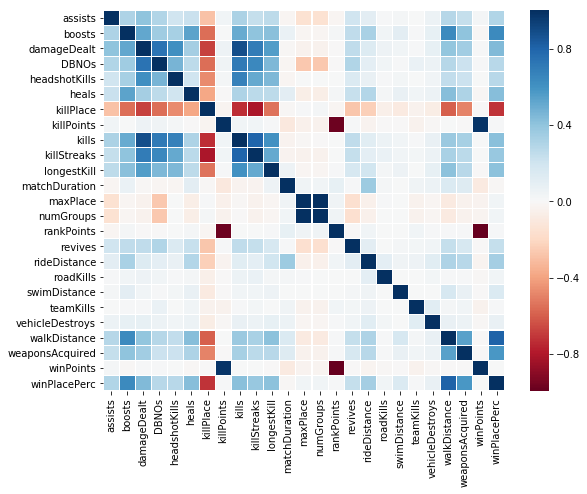

KeyError: 'groupId'

In [5]:
def reload():
    gc.collect()
    df = pd.read_csv('train_V2.csv')
    invalid_match_ids = df[df['winPlacePerc'].isna()]['matchId'].values
    df = df[-df['matchId'].isin(invalid_match_ids)]
    return df
df = reload()

cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
corr = df[cols_to_fit].corr()

plt.figure(figsize=(9,7))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

agg = df.groupby(['groupId']).size().to_frame('players_in_team')
df = df.merge(agg, how='left', on=['groupId'])
df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
df['headshotKills_over_kills'].fillna(0, inplace=True)
df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
df['killPlace_over_maxPlace'].fillna(0, inplace=True)
df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
corr = df[['killPlace', 'walkDistance', 'players_in_team', 'headshotKills_over_kills', 'killPlace_over_maxPlace', 'winPlacePerc']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()


In [4]:
df.head(3)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.8,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.0,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.8,2,0,0.7755


[20]	valid_0's l1: 0.0648862
[40]	valid_0's l1: 0.0617668
[60]	valid_0's l1: 0.0605104
[80]	valid_0's l1: 0.0599227
[100]	valid_0's l1: 0.0595812


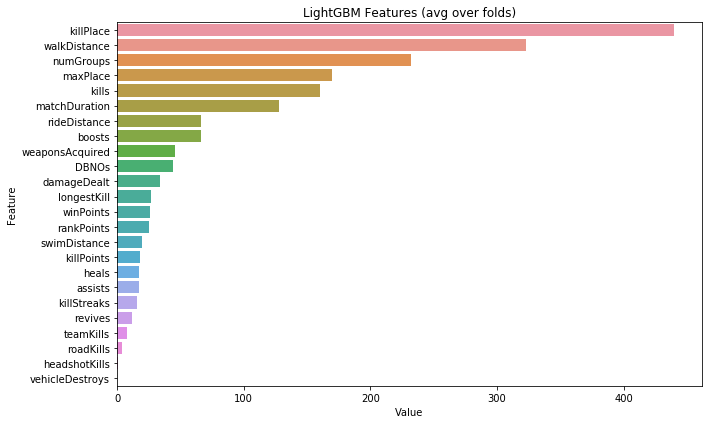

In [7]:
def train_test_split(df, test_size=0.1):
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1 - test_size))
    train_match_ids = random.sample(match_ids, train_size)

    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    
    return train, test

df = reload()

# Option 1: Give it as category
# df['matchType'] = df['matchType'].astype('category')
# Option 2: pd.dummies
# df = pd.concat([df, pd.get_dummies(df['matchType'])], axis=1)
# Option 3: Drop it for now (Not the best solution)
df.drop(columns=['matchType'], inplace=True)

target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', target]
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
train, val = train_test_split(df, 0.1)

from lightgbm import LGBMRegressor
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 20,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}

model = LGBMRegressor(**params)
#Fitting the model 
model.fit(
    train[cols_to_fit], train[target],
    eval_set=[(val[cols_to_fit], val[target])],
    eval_metric='mae',
    verbose=20,
)

feature_importance = pd.DataFrame(sorted(zip(model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()


In [8]:
#Permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=42).fit(val[cols_to_fit], val[target])
eli5.show_weights(perm, feature_names=list(cols_to_fit))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Weight,Feature
1.3131 ± 0.0037,killPlace
0.3400 ± 0.0021,kills
0.3040 ± 0.0012,walkDistance
0.1059 ± 0.0002,numGroups
0.0573 ± 0.0004,maxPlace
0.0304 ± 0.0003,matchDuration
0.0125 ± 0.0002,killStreaks
0.0070 ± 0.0001,rideDistance
0.0066 ± 0.0001,boosts
0.0039 ± 0.0001,weaponsAcquired
